In [10]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import recommender
from recommender.implicit_bpr_recommender import ImplicitBPRRecommender
from recommender import FactorizationRecommender, BPRRecommender, WalsRecommender, ImplicitWalsRecommender
from matrix_builder import ReportTechniqueMatrixBuilder
from tie import TechniqueInferenceEngine
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [12]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()
# split into training and test data
train_and_validation_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
validation_indices = frozenset(random.sample(tuple(train_and_validation_indices), k=math.floor((1-validation_ratio) * len(train_and_validation_indices))))
train_indices = frozenset(train_and_validation_indices).difference(validation_indices)
test_indices = frozenset(data.indices).difference(train_and_validation_indices)
training_data = data.mask(train_indices)
validation_data = data.mask(validation_indices)
test_data = data.mask(test_indices)

In [21]:
embedding_dimension = 10
k = 20

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit_with_cross_validation(
    learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
    num_iterations=[1000],
    regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
    gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

hyperparameters {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.005, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.01, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.02, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.05, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.1, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.2, 'regularization_coefficient': 0.001, 'num_iterations': 1000, 'learning_rate': 0.001}
hyperparameters {'gravity_coefficient': 0.3, 'regularization_coefficient': 0.001, '

In [24]:
# hyperparameters
embedding_dimension = 10
k = 20

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit_with_cross_validation(
    learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
    num_iterations=[500 * 512],
    regularization=[0, 0.0001, 0.001, 0.01],
)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

hyperparameters {'v_j_regularization': 0.0001, 'v_i_regularization': 0.0001, 'w_regularization': 0, 'num_iterations': 256000, 'learning_rate': 0.001}
score for hyperparameters 0.023778867720160093
hyperparameters {'v_j_regularization': 0.0001, 'v_i_regularization': 0.0001, 'w_regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.001}
score for hyperparameters 0.029006011499219785
hyperparameters {'v_j_regularization': 0.0001, 'v_i_regularization': 0.0001, 'w_regularization': 0.001, 'num_iterations': 256000, 'learning_rate': 0.001}
score for hyperparameters 0.039263264941108315
hyperparameters {'v_j_regularization': 0.0001, 'v_i_regularization': 0.0001, 'w_regularization': 0.01, 'num_iterations': 256000, 'learning_rate': 0.001}
score for hyperparameters 0.054997102470444724
hyperparameters {'v_j_regularization': 0.0001, 'v_i_regularization': 0.0001, 'w_regularization': 0, 'num_iterations': 256000, 'learning_rate': 0.005}
score for hyperparameters 0.11629463140829277
hype

In [35]:
# hyperparameters
embedding_dimension = 10
k = 20

model = ImplicitBPRRecommender(k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit_with_cross_validation(
    learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
    num_iterations=[math.floor(500 * 512 / training_data.to_numpy().sum())],
    regularization=[0, 0.0001, 0.001, 0.01],
)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

hyperparameters {'regularization': 0, 'num_iterations': 67, 'learning_rate': 0.001}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.05903905680514567
hyperparameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.001}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.07618356177980001
hyperparameters {'regularization': 0.001, 'num_iterations': 67, 'learning_rate': 0.001}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.033254644489289935
hyperparameters {'regularization': 0.01, 'num_iterations': 67, 'learning_rate': 0.001}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.05905181760066512
hyperparameters {'regularization': 0, 'num_iterations': 67, 'learning_rate': 0.005}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.06140444926593436
hyperparameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.005}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.05866354438048306
hyperparameters {'regularization': 0.001, 'num_iterations': 67, 'learning_rate': 0.005}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.06375342584252092
hyperparameters {'regularization': 0.01, 'num_iterations': 67, 'learning_rate': 0.005}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.044278800579778295
hyperparameters {'regularization': 0, 'num_iterations': 67, 'learning_rate': 0.01}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.058102425424125304
hyperparameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.01}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.038200715314319
hyperparameters {'regularization': 0.001, 'num_iterations': 67, 'learning_rate': 0.01}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.036340014550713784
hyperparameters {'regularization': 0.01, 'num_iterations': 67, 'learning_rate': 0.01}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.053321555899591665
hyperparameters {'regularization': 0, 'num_iterations': 67, 'learning_rate': 0.02}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.046841278056879244
hyperparameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.02}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.048403637506916744
hyperparameters {'regularization': 0.001, 'num_iterations': 67, 'learning_rate': 0.02}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.04378670840467754
hyperparameters {'regularization': 0.01, 'num_iterations': 67, 'learning_rate': 0.02}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.04414755954968812
hyperparameters {'regularization': 0, 'num_iterations': 67, 'learning_rate': 0.05}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.03551287779086217
hyperparameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.05}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.034188068100035995
hyperparameters {'regularization': 0.001, 'num_iterations': 67, 'learning_rate': 0.05}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.03564968921746598
hyperparameters {'regularization': 0.01, 'num_iterations': 67, 'learning_rate': 0.05}


  0%|          | 0/67 [00:00<?, ?it/s]

score for hyperparameters 0.03215088676081219
best hyper parameters {'regularization': 0.0001, 'num_iterations': 67, 'learning_rate': 0.001}


  0%|          | 0/67 [00:00<?, ?it/s]

Mean Squared Error None
Precision 0.0019163206643244969
Recall 0.015189820181530216
Normalized Discounted Cumulative Gain 0.014312868387378032


In [13]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'num_iterations': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

/opt/homebrew/anaconda3/envs/tie/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

Mean Squared Error 0.9879127664637455
Precision 0.04024273395081444
Recall 0.38474900928814565
Normalized Discounted Cumulative Gain 0.08508324107004171


In [15]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.1, 'c': 0.5, 'num_iterations': 20}

model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

ValueError: Input contains NaN.

recalls [0.3108950826166713, 0.33106441277117776, 0.35140350191851905, 0.3776813026138787, 0.3966996638586128, 0.411765460559823, 0.4233605407166355, 0.43163018227607586, 0.4401672609201304, 0.4468014756671896, 0.4517191463880229, 0.4559514819727501, 0.46077787828357303, 0.46526590374333276, 0.46870873797526247, 0.4723130017041636, 0.47641192896661694, 0.47992833763513354, 0.48201683166709614, 0.4847402939021784, 0.4867623192471993]


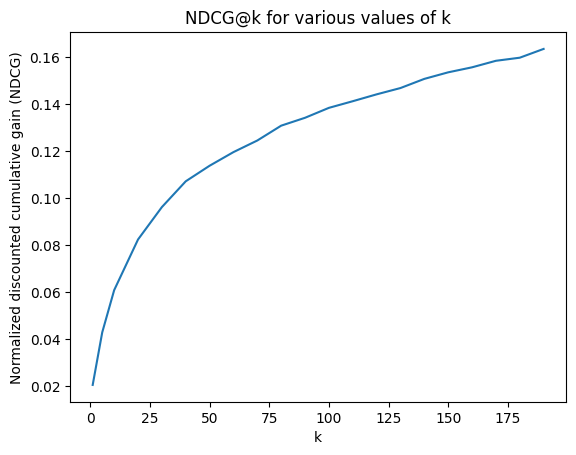

In [9]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    # print("Mean Squared Error", mse)
    precision = tie.precision(k=k)
    # print("Precision", precision)
    recall = tie.recall(k=k)
    recalls.append(recall)
    # print("Recall", recall)
    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)
    # print("Normalized Discounted Cumulative Gain", ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [50]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, c=0.5, regularization_coefficient=0.05)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1027         0.514432            1.0        0.0   
T1082         0.491166            1.0        0.0   
T1105         0.480862            1.0        0.0   
T1071.001     0.446578            1.0        0.0   
T1070.004     0.345796            1.0        0.0   
T1566.001     0.245225            0.0        0.0   
T1059.003     0.231526            1.0        0.0   
T1547         0.226621            0.0        0.0   
T1059.005     0.219641            1.0        0.0   
T1055         0.215389            0.0        0.0   

                              technique_name  
T1027        Obfuscated Files or Information  
T1082           System Information Discovery  
T1105                  Ingress Tool Transfer  
T1071.001                      Web Protocols  
T1070.004                      File Deletion  
T1566.001           Spearphishing Attachment  
T1059.003              Windows Command Shell  
T1547      Boot or Logon Autostart Execution  
T105

In [6]:
# COLD START PREDICTOR
# use one of the below sets of techniques or use your own!

# training_techniques = set(['T1021.004', 'T1572', 'T1083', 'T1570', 'T1571', 'T1105', 'T1003.001',
#     'T1005', 'T1056.001', 'T1140', 'T1555.003', 'T1569.002', 'T1113',
#     'T1018', 'T1112'
# ])
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"}
oilrig_adversary_emulation_plan_techniques = {"T1082", "T1033", "T1016", "T1087.002", "T1069.002", "T1021", "T1087.001", "T1069.001", "T1049", "T1057", "T1007", "T1012", "T1018", "T1555.004", "T1041", "T1105", "T1505.003", "T1003.001", "T1070.004", "T1572", "T1021.001", "T1569.002", "T1083", "T1048.003"}
# solarigate_techniques = set(["T1087", "T1087.002", "T1098.001", "T1098.002", "T1098.003", "T1098.005",
#     "T1583.001", "T1071.001", "T1560.001", "T1059.001", "T1059.003", "T1059.005",
#     "T1584.001", "T1555", "T1555.003", "T1213", "T1213.003", "T1005", "T1074.002",
#     "T1140", "T1587.001", "T1484.002", "T1482", "T1568", "T1114.002", "T1546.003",
#     "T1048.002", "T1190", "T1133", "T1083", "T1606.001", "T1606.002", "T1589.001",
#     "T1562.001", "T1562.002", "T1562.004", "T1070", "T1070.004", "T1070.006", "T1070.008",
#     "T1105", "T1036", "T1036.004", "T1036.005", "T1003.006", "T1069", "T1069.002",
#     "T1057", "T1090.001", "T1021.001", "T1021.002", "T1021.006", "T1018", "T1053.005",
#     "T1558.003", "T1539", "T1559.002", "T1195.002", "T1218.011", "T1082", "T1016.001",
#     "T1199", "T1552.004", "T1550", "T1550.001", "T1550.004", "T1078",
#     "T1078.002", "T1078.003", "T1078.004", "T1047",
# ])

factorization_kwargs = {
    "learning_rate": 0.5,
    "num_iterations": 10,
    "regularization_coefficient": 0.1,
    "gravity_coefficient": 1,
}

bpr_kwargs = {
    "learning_rate": 0.01,
    "num_iterations": 1000,
    "w_regularization": 0.001,
}

new_report_predictions = tie.predict_for_new_report(
    oilrig_techniques,
    **bpr_kwargs,
)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1052         0.977235            0.0        0.0   
T1133         0.899625            0.0        0.0   
T1021.002     0.787500            0.0        0.0   
T1202         0.758203            0.0        0.0   
T1596.004     0.742823            0.0        0.0   
T1505.002     0.721428            0.0        0.0   
T1594         0.714414            0.0        0.0   
T1546.001     0.676589            0.0        0.0   
T1105         0.658036            1.0        0.0   
T1104         0.648065            0.0        0.0   

                              technique_name  
T1052      Exfiltration Over Physical Medium  
T1133               External Remote Services  
T1021.002           SMB/Windows Admin Shares  
T1202             Indirect Command Execution  
T1596.004                               CDNs  
T1505.002                    Transport Agent  
T1594           Search Victim-Owned Websites  
T1546.001    Change Default File Association  
T110

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6263 samples in 0.002s...
[t-SNE] Computed neighbors for 6263 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6263
[t-SNE] Computed conditional probabilities for sample 2000 / 6263
[t-SNE] Computed conditional probabilities for sample 3000 / 6263
[t-SNE] Computed conditional probabilities for sample 4000 / 6263
[t-SNE] Computed conditional probabilities for sample 5000 / 6263
[t-SNE] Computed conditional probabilities for sample 6000 / 6263
[t-SNE] Computed conditional probabilities for sample 6263 / 6263
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.487518
[t-SNE] KL divergence after 5200 iterations: 1.522853


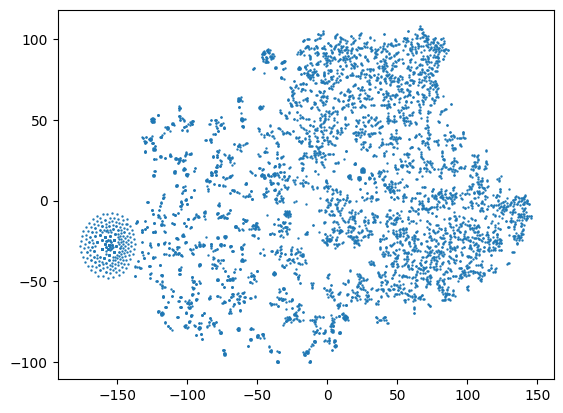

In [24]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=20,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()